# Surface scan for a PBN objective function
This can perform 1-D scan for a single node or 2-D scan for two nodes,
each node must have exactly two alternative rules.  

In [13]:
import sys
import importlib
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('./src')
from BNMPy import booleanNetwork as bn
from BNMPy import BMatrix
from Optimizer.simulation_evaluator import SimulationEvaluator
from Optimizer.experiment_data import ExperimentData

network_file = '../input_files/Eduati2020_standardized_no_expand.txt'
data_aspc1_file = '../data/Eduati2020_AsPC1_cleaned.csv'

config = {
            'steady_state': {
                'method': 'monte_carlo', 
                'monte_carlo_params': {
                    'n_runs': 2,
                    'n_steps': 10000,
                    'p_noise': 0
                }
            }
        }

def BN2PBN(bn_string, prob=0.5):
    """
    Expand the boolean network to a PBN by adding a self-loop as alternative function
    prob: probability of the equations from the original BN

    Returns:
        pbn_string: string of the PBN
        nodes_to_optimize: list of nodes excludes input nodes
    """
    # Parse equations from BN
    bn_equations = {}
    for line in bn_string.strip().split('\n'):
        if '=' in line:
            target, rule = line.split('=', 1)
            bn_equations[target.strip()] = rule.strip()
    
    # Expand rules
    pbn_equations = []
    nodes_to_optimize = []

    for target in bn_equations.keys():
        if bn_equations[target] == target:
            # If its already a self-loop (e.g., a input node)
            pbn_equations.append(f"{target} = {bn_equations[target]}, 1")
        else:
            # Add the original rule with a prob
            pbn_equations.append(f"{target} = {bn_equations[target]}, {prob}")
            # Add the alternative rule
            pbn_equations.append(f"{target} = {target}, {round(1-prob,2)}")
            nodes_to_optimize.append(target)
    
    # remove equations with prob = 0
    pbn_equations = [eq for eq in pbn_equations if eq.split(',')[1] != ' 0']
    pbn_string = '\n'.join(pbn_equations)
    return pbn_string, nodes_to_optimize

with open(network_file, 'r') as f:
    bn_string = f.read()

pbn_string, _ = BN2PBN(bn_string, prob=0.5)
pbn = BMatrix.load_pbn_from_string(pbn_string)

def build_parameter_grid(n_nodes, steps):
    """Return an iterator over (prob_vec, grid_coords)."""
    if n_nodes == 1:
        grid = np.linspace(0.0, 1.0, steps[0])
        for p in grid:
            yield np.array([p, 1.0 - p]), (p,)
    elif n_nodes == 2:
        g1 = np.linspace(0.0, 1.0, steps[0])
        g2 = np.linspace(0.0, 1.0, steps[1])
        for p1 in g1:
            for p2 in g2:
                prob_vec = np.array([p1, 1.0 - p1, p2, 1.0 - p2])
                yield prob_vec, (p1, p2)
    else:
        raise ValueError("Surface scan supports only 1 or 2 nodes.")

def surface_scan(nodes, steps):
    experiments = ExperimentData.load_from_csv(data_aspc1_file)
    steps = [steps] * len(nodes)
    evaluator = SimulationEvaluator(
        pbn,
        experiments,
        config=config,             
        nodes_to_optimize=nodes   
    )
    dim = len(nodes)
    mse_values = []
    i = 0
    print(f"Scanning {dim}-D surface over {steps[0]} steps …")
    for prob_vec, coords in build_parameter_grid(dim, steps):
        i += 1
        mse = evaluator.objective_function(prob_vec)
        print(f"Running step {i}/{steps[0]}   MSE: {mse}")
        mse_values.append((coords, mse))

    # ---------- plotting ----------
    if dim == 1:
        xs = [c[0] for c, _ in mse_values]
        ys = [m for _, m in mse_values]
        plt.plot(xs, ys, marker="o")
        plt.xlabel(f"P({nodes[0]} rule #1)")
        plt.ylabel("MSE")
        plt.title(f"Objective surface for {nodes[0]}")
    else:
        g1 = np.linspace(0.0, 1.0, steps[0])
        g2 = np.linspace(0.0, 1.0, steps[1])
        Z = np.zeros((len(g2), len(g1)))
        for (p1, p2), mse in mse_values:
            i = np.where(np.isclose(g1, p1))[0][0]
            j = np.where(np.isclose(g2, p2))[0][0]
            Z[j, i] = mse
        plt.imshow(Z, origin="lower",
                    extent=[0, 1, 0, 1], aspect="auto")
        plt.colorbar(label="MSE")
        plt.xlabel(f"P({nodes[0]} rule #1)")
        plt.ylabel(f"P({nodes[1]} rule #1)")
        plt.title(f"Objective surface for {nodes[0]} vs {nodes[1]}")
    plt.tight_layout()
    plt.show()
    

No initial state provided, using a random initial state
PBN loaded successfully. There are 46 genes in the network.


In [8]:
pbn_string

'AKT1 = AktM & AktP, 0.5\nAKT1 = AKT1, 0.5\nAPAF1 = TP53, 0.5\nAPAF1 = APAF1, 0.5\nAPC = APAF1 & CASP9 & Mito | ! BIRC2, 0.5\nAPC = APC, 0.5\nAktM = PDPK1 & PIP3, 0.5\nAktM = AktM, 0.5\nAktP = PDPK1 & PIP3, 0.5\nAktP = AktP, 0.5\nBAD = TP53 | ! RPS6KA1 | ! AKT1, 0.5\nBAD = BAD, 0.5\nBCL2L1 = ! TP53 | STAT3 | NFKB1 | ! BAD, 0.5\nBCL2L1 = BCL2L1, 0.5\nBID = MAPK8 & TP53 | CASP8 & TP53 | ! BCL2L1, 0.5\nBID = BID, 0.5\nBIRC2 = ! CASP3 & ! CASP6 | NFKB1 | ! Mito, 0.5\nBIRC2 = BIRC2, 0.5\nCASP12 = CASP7, 0.5\nCASP12 = CASP12, 0.5\nCASP3 = ! BIRC2 | CASP8 | CASP6 | APC, 0.5\nCASP3 = CASP3, 0.5\nCASP6 = ! BIRC2 | CASP3, 0.5\nCASP6 = CASP6, 0.5\nCASP7 = ! BIRC2 | CASP8 | APC, 0.5\nCASP7 = CASP7, 0.5\nCASP8 = complexIIB | complexIIA | CASP6, 0.5\nCASP8 = CASP8, 0.5\nCASP9 = ! BIRC2 | ! MAPK1 | CASP3 | CASP12 | ! AKT1, 0.5\nCASP9 = CASP9, 0.5\nCFLAR = NFKB1, 0.5\nCFLAR = CFLAR, 0.5\nEGF = EGF, 1\nEGFR = EGF, 0.5\nEGFR = EGFR, 0.5\nIKBKB = complexI | PDPK1 | AKT1 | ! TNFAIP3, 0.5\nIKBKB = IKBKB, 0

Scanning 1-D surface over 30 steps …
Running step 1/30   MSE: 0.3285919901716396
Running step 2/30   MSE: 0.32861162962027013
Running step 3/30   MSE: 0.3302960475691386
Running step 4/30   MSE: 0.32863459229999914
Running step 5/30   MSE: 0.33192041869112676
Running step 6/30   MSE: 0.3298063500338456
Running step 7/30   MSE: 0.3286717731195593
Running step 8/30   MSE: 0.32890089736753175
Running step 9/30   MSE: 0.3286347521362144
Running step 10/30   MSE: 0.3280488263763561
Running step 11/30   MSE: 0.3291688585158858
Running step 12/30   MSE: 0.32872569062930646
Running step 13/30   MSE: 0.32928090315207453
Running step 14/30   MSE: 0.32911901151773076
Running step 15/30   MSE: 0.32958860864032236
Running step 16/30   MSE: 0.32849499338373667
Running step 17/30   MSE: 0.32689513478135823
Running step 18/30   MSE: 0.32857032189007124
Running step 19/30   MSE: 0.3307602365079252
Running step 20/30   MSE: 0.32747781163314277
Running step 21/30   MSE: 0.3303734300165248
Running step 22

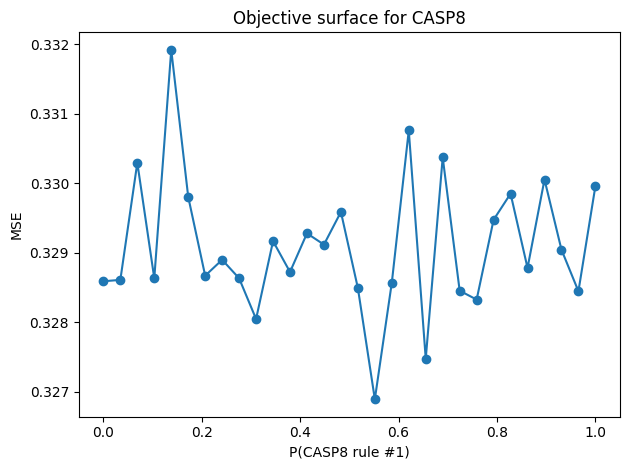

In [2]:
surface_scan(['CASP8'], 30)

Scanning 1-D surface over 30 steps …
Running step 1/30   MSE: 0.3454107424481567
Running step 2/30   MSE: 0.3437105949205118
Running step 3/30   MSE: 0.34222124840044027
Running step 4/30   MSE: 0.34141009572271797
Running step 5/30   MSE: 0.3391675279860181
Running step 6/30   MSE: 0.33768115204044746
Running step 7/30   MSE: 0.3370029205695223
Running step 8/30   MSE: 0.3374109015045952
Running step 9/30   MSE: 0.3350781301098342
Running step 10/30   MSE: 0.33529665961565824
Running step 11/30   MSE: 0.33316330840817304
Running step 12/30   MSE: 0.332575338914676
Running step 13/30   MSE: 0.33162127598990376
Running step 14/30   MSE: 0.33030379467575444
Running step 15/30   MSE: 0.32976271972653154
Running step 16/30   MSE: 0.32915573033279255
Running step 17/30   MSE: 0.32821940920357434
Running step 18/30   MSE: 0.3271097695709427
Running step 19/30   MSE: 0.32445787677349736
Running step 20/30   MSE: 0.3251353469765897
Running step 21/30   MSE: 0.32357040975634377
Running step 22/

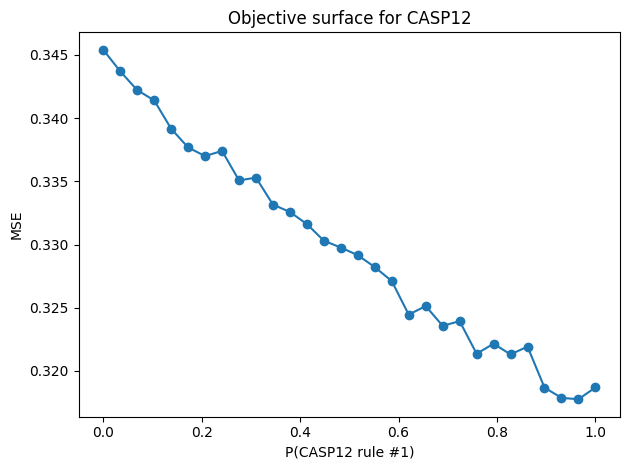

In [5]:
surface_scan(['CASP12'], 30)

Scanning 1-D surface over 30 steps …
Running step 1/30   MSE: 0.3213536335868502
Running step 2/30   MSE: 0.32927089032013346
Running step 3/30   MSE: 0.3262996637828408
Running step 4/30   MSE: 0.3285479782688461
Running step 5/30   MSE: 0.3292693625035109
Running step 6/30   MSE: 0.32771054982967
Running step 7/30   MSE: 0.3280259213245639
Running step 8/30   MSE: 0.3293681307749105
Running step 9/30   MSE: 0.33077552090048307
Running step 10/30   MSE: 0.3287478554173762
Running step 11/30   MSE: 0.32903616082848414
Running step 12/30   MSE: 0.3286216677274175
Running step 13/30   MSE: 0.3293923862708086
Running step 14/30   MSE: 0.3276898787251126
Running step 15/30   MSE: 0.3296840073328155
Running step 16/30   MSE: 0.32872365296792844
Running step 17/30   MSE: 0.3283116008405999
Running step 18/30   MSE: 0.32951400872189324
Running step 19/30   MSE: 0.327302664236518
Running step 20/30   MSE: 0.32791349685621674
Running step 21/30   MSE: 0.3306945616303407
Running step 22/30   MSE

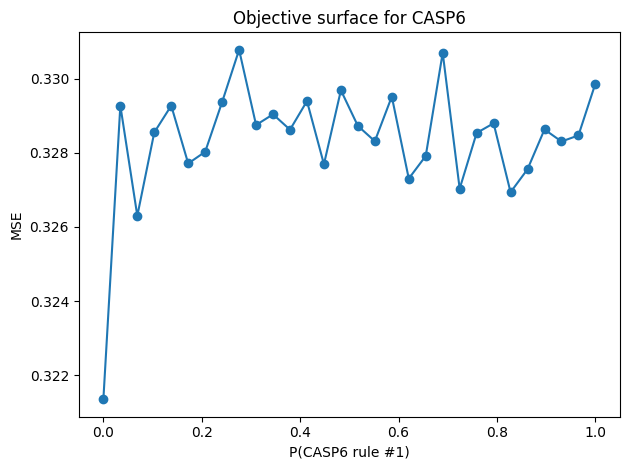

In [3]:
surface_scan(['CASP6'], 30)

Scanning 1-D surface over 30 steps …
Running step 1/30   MSE: 0.33132347497937076
Running step 2/30   MSE: 0.3306514668993401
Running step 3/30   MSE: 0.3328105015864576
Running step 4/30   MSE: 0.3317500572343705
Running step 5/30   MSE: 0.3317121013295962
Running step 6/30   MSE: 0.33119106860624076
Running step 7/30   MSE: 0.3299221589044983
Running step 8/30   MSE: 0.3305846727987784
Running step 9/30   MSE: 0.3286839060229339
Running step 10/30   MSE: 0.33136408641918347
Running step 11/30   MSE: 0.3295962634844045
Running step 12/30   MSE: 0.33024258705621906
Running step 13/30   MSE: 0.33064352153722526
Running step 14/30   MSE: 0.3292339259220054
Running step 15/30   MSE: 0.3278659003531684
Running step 16/30   MSE: 0.3272563096779173
Running step 17/30   MSE: 0.32976238585495843
Running step 18/30   MSE: 0.3283993794280054
Running step 19/30   MSE: 0.32739522403555754
Running step 20/30   MSE: 0.32958002133200376
Running step 21/30   MSE: 0.3273386919866828
Running step 22/30 

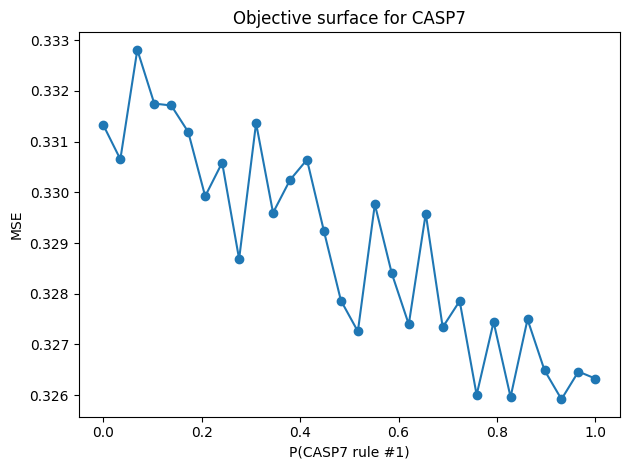

In [4]:
surface_scan(['CASP7'], 30)

Scanning 1-D surface over 30 steps …
Running step 1/30   MSE: 0.3216837212648806
Running step 2/30   MSE: 0.3210316930068979
Running step 3/30   MSE: 0.32263122218626333
Running step 4/30   MSE: 0.32323760294303244
Running step 5/30   MSE: 0.3229526623038802
Running step 6/30   MSE: 0.3244785209331358
Running step 7/30   MSE: 0.3238807009079798
Running step 8/30   MSE: 0.3235116801984029
Running step 9/30   MSE: 0.32483362812976224
Running step 10/30   MSE: 0.3249150165548732
Running step 11/30   MSE: 0.3225232759636829
Running step 12/30   MSE: 0.3252815191686976
Running step 13/30   MSE: 0.324745761512722
Running step 14/30   MSE: 0.32507903405807187
Running step 15/30   MSE: 0.3258103354159525
Running step 16/30   MSE: 0.32646294919124774
Running step 17/30   MSE: 0.32566062766586573
Running step 18/30   MSE: 0.32591639502606423
Running step 19/30   MSE: 0.3256574586645556
Running step 20/30   MSE: 0.324940472775725
Running step 21/30   MSE: 0.32413236575064613
Running step 22/30   

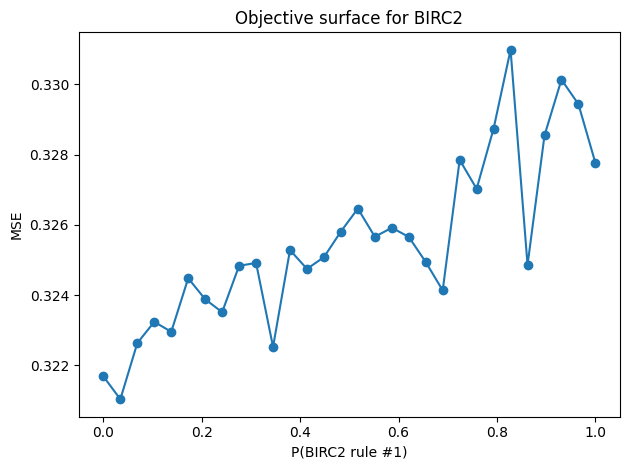

In [5]:
surface_scan(['BIRC2'], 30)

Scanning 2-D surface over 20 steps …
Running step 1/20   MSE: 0.3460633787536347
Running step 2/20   MSE: 0.3436182830139954
Running step 3/20   MSE: 0.34124121205460123
Running step 4/20   MSE: 0.3402175137675824
Running step 5/20   MSE: 0.3398595236157528
Running step 6/20   MSE: 0.33507091952735285
Running step 7/20   MSE: 0.3337840386782617
Running step 8/20   MSE: 0.33362569628172145
Running step 9/20   MSE: 0.3327297158477007
Running step 10/20   MSE: 0.3308067484852421
Running step 11/20   MSE: 0.3297423108304388
Running step 12/20   MSE: 0.32520624638965984
Running step 13/20   MSE: 0.3257701136817142
Running step 14/20   MSE: 0.3274876881676144
Running step 15/20   MSE: 0.325396175284038
Running step 16/20   MSE: 0.3265910446549645
Running step 17/20   MSE: 0.32577573942617594
Running step 18/20   MSE: 0.3236072989953158
Running step 19/20   MSE: 0.3205850428843287
Running step 20/20   MSE: 0.3199839009478166
Running step 21/20   MSE: 0.3464256464994978
Running step 22/20   MS

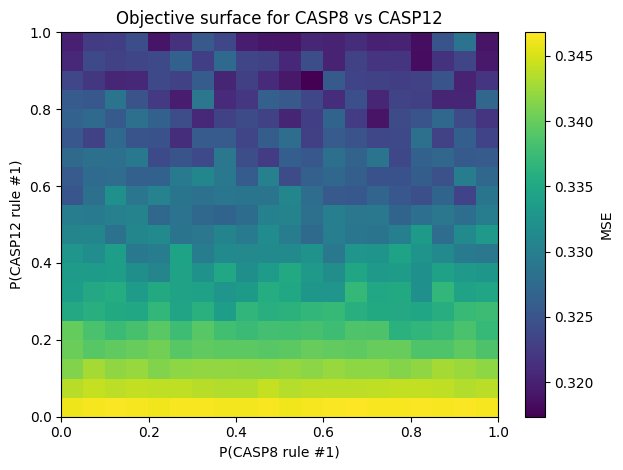

In [6]:
surface_scan(['CASP8', 'CASP12'], 20)

Scanning 2-D surface over 20 steps …
Running step 1/20   MSE: 0.31489779359093445
Running step 2/20   MSE: 0.31572609567153803
Running step 3/20   MSE: 0.31985707130946367
Running step 4/20   MSE: 0.3192370055538415
Running step 5/20   MSE: 0.3141795633078312
Running step 6/20   MSE: 0.31643401849723085
Running step 7/20   MSE: 0.3167805828900167
Running step 8/20   MSE: 0.3141275883934476
Running step 9/20   MSE: 0.3146850561834462
Running step 10/20   MSE: 0.32167872367025996
Running step 11/20   MSE: 0.31545990365815874
Running step 12/20   MSE: 0.3178574832696233
Running step 13/20   MSE: 0.31183805070435244
Running step 14/20   MSE: 0.3177775080506714
Running step 15/20   MSE: 0.31833546496649134
Running step 16/20   MSE: 0.3138512871006793
Running step 17/20   MSE: 0.31567867887666007
Running step 18/20   MSE: 0.3162245065972522
Running step 19/20   MSE: 0.31673274316102223
Running step 20/20   MSE: 0.31483968760612235
Running step 21/20   MSE: 0.32365848477487036
Running step 22

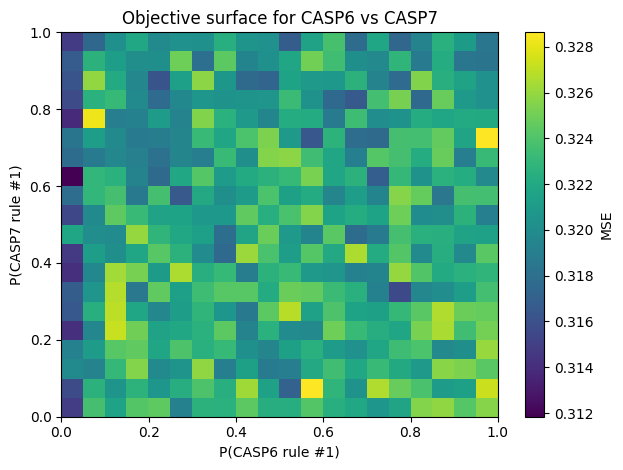

In [7]:
surface_scan(['CASP6', 'CASP7'], 20)

# Optimize one at a time

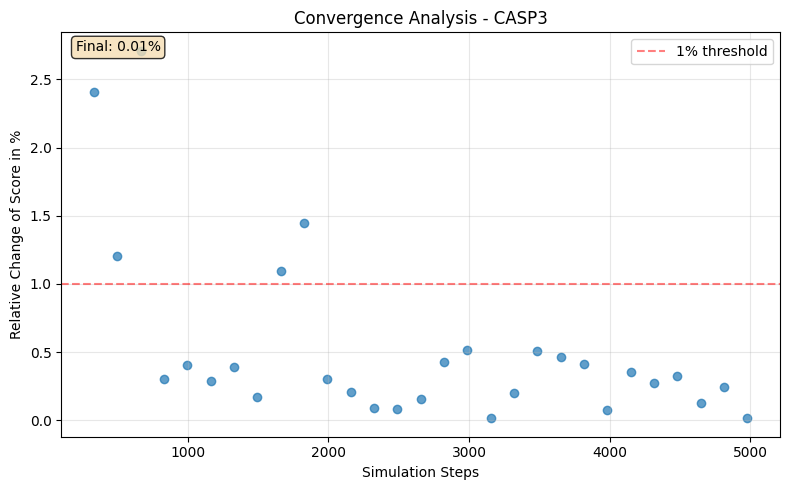

(array([0.32027189, 0.67932827, 0.5977609 , 0.4870052 , 0.49460216,
        0.88484606, 0.7784886 , 0.72131148, 0.73970412, 0.78368653,
        0.90803679, 0.83846461, 0.8732507 , 0.89644142, 0.90163934,
        0.65693723, 1.        , 0.8952419 , 0.87564974, 0.        ,
        0.3802479 , 0.58976409, 0.72970812, 0.74570172, 0.49420232,
        0.53898441, 0.6177529 , 0.70371851, 0.70971611, 0.68372651,
        0.67612955, 0.66173531, 0.76409436, 0.7684926 , 0.71891244,
        0.53218713, 0.5289884 , 0.71491403, 0.37465014, 0.38064774,
        0.52938824, 0.65053978, 0.72530988, 0.67013195, 0.71131547,
        0.70851659]),
 {'final_relative_change': 0.013848497438029295,
  'converged': True,
  'node_analyzed': 'CASP3',
  'relative_changes': [2.409638554216864,
   1.2048192771084265,
   2.7108433734939763,
   0.3012048192771122,
   0.40160642570281624,
   0.2868617326448608,
   0.38726333907056487,
   0.16733601070950677,
   1.0977242302543488,
   1.4457831325301207,
   0.30120481927

In [25]:
importlib.reload(sys.modules['BNMPy.steady_state'])
from BNMPy.steady_state import SteadyStateCalculator

calc = SteadyStateCalculator(pbn)
calc.set_experimental_conditions(stimuli=['EGF'],inhibitors=['JAK1'])
calc.compute_steady_state(method='monte_carlo',n_runs=3,n_steps=5000,p_noise=0.05,analyze_convergence=True,output_node='CASP3')

In [31]:
# Configure optimizer
from Optimizer.parameter_optimizer import ParameterOptimizer
config = {
    'pso_params': {
        'n_particles': 20,  # 20*number of parameters to optimize
        'iters': 100,
        'options': {
            'c1': 0.5, # Cognitive parameter
            'c2': 0.3, # Social parameter
            'w': 0.9 # Inertia weight
        },
        'ftol': 0.00001,
        'ftol_iter': 10
    },
    'steady_state': {
        'method': 'monte_carlo',
            'monte_carlo_params': {
                'n_runs': 3,
                'n_steps': 5000,
                'p_noise': 0.05
            }
    },
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 1, # threshold for accepting fit,
    'display_rules_every': 0  # Display optimized rules every n iterations (0 = disabled)
}

CASP12
#1: ftol = 0.001, ftol_iter = 5
MSE = 0.217028, p = 0.8743

#2: ftol = 0.00001, ftol_iter = 10
MSE = 0.210477, p = 0.9780

CASP8
#1: ftol = 0.001, ftol_iter = 5
MSE = 0.214634, p = 0.0925

#2: ftol = 0.00001, ftol_iter = 10
MSE = 0.206699, p = 0.0174

CASP6
#1: ftol = 0.00001, ftol_iter = 10
MSE = 0.189035, p = 0.0095

CASP7
#1: ftol = 0.00001, ftol_iter = 10


In [32]:
optimizer = ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned.csv', 
    config=config, 
    nodes_to_optimize=['CASP12'], 
    verbose=True)
result = optimizer.optimize(method='particle_swarm')

2025-07-19 23:03:22,276 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Running optimization using method: particle_swarm
Maximum attempts: 2

--- Attempt 1/2 ---
PSO early stopping enabled:
  - Function tolerance: 1e-05
  - Tolerance iterations: 10


PSO Setup:
  - Particles: 20
  - Max iterations: 100
  - Problem dimensions: 2
  - Total function evaluations: 2000



pyswarms.single.global_best:   1%|          |1/100, best_cost=0.215

PSO Iteration 1: Current best MSE: 0.214874, Global best MSE: 0.214874


pyswarms.single.global_best:   2%|▏         |2/100, best_cost=0.213

PSO Iteration 2: Current best MSE: 0.212717, Global best MSE: 0.212717


pyswarms.single.global_best:   3%|▎         |3/100, best_cost=0.213

PSO Iteration 3: Current best MSE: 0.213737, Global best MSE: 0.212717


pyswarms.single.global_best:   4%|▍         |4/100, best_cost=0.213

PSO Iteration 4: Current best MSE: 0.214828, Global best MSE: 0.212717


pyswarms.single.global_best:   5%|▌         |5/100, best_cost=0.211

PSO Iteration 5: Current best MSE: 0.211019, Global best MSE: 0.211019


pyswarms.single.global_best:   6%|▌         |6/100, best_cost=0.211

PSO Iteration 6: Current best MSE: 0.213392, Global best MSE: 0.211019


pyswarms.single.global_best:   7%|▋         |7/100, best_cost=0.211

PSO Iteration 7: Current best MSE: 0.214694, Global best MSE: 0.211019


pyswarms.single.global_best:   8%|▊         |8/100, best_cost=0.211

PSO Iteration 8: Current best MSE: 0.213479, Global best MSE: 0.211019


pyswarms.single.global_best:   9%|▉         |9/100, best_cost=0.211

PSO Iteration 9: Current best MSE: 0.215460, Global best MSE: 0.211019


pyswarms.single.global_best:  10%|█         |10/100, best_cost=0.211

PSO Iteration 10: Current best MSE: 0.214691, Global best MSE: 0.211019


pyswarms.single.global_best:  11%|█         |11/100, best_cost=0.211

PSO Iteration 11: Current best MSE: 0.213250, Global best MSE: 0.211019


pyswarms.single.global_best:  12%|█▏        |12/100, best_cost=0.211

PSO Iteration 12: Current best MSE: 0.213229, Global best MSE: 0.211019


pyswarms.single.global_best:  13%|█▎        |13/100, best_cost=0.21 

PSO Iteration 13: Current best MSE: 0.210477, Global best MSE: 0.210477


pyswarms.single.global_best:  14%|█▍        |14/100, best_cost=0.21

PSO Iteration 14: Current best MSE: 0.213070, Global best MSE: 0.210477


pyswarms.single.global_best:  15%|█▌        |15/100, best_cost=0.21

PSO Iteration 15: Current best MSE: 0.211918, Global best MSE: 0.210477


pyswarms.single.global_best:  16%|█▌        |16/100, best_cost=0.21

PSO Iteration 16: Current best MSE: 0.212689, Global best MSE: 0.210477


pyswarms.single.global_best:  17%|█▋        |17/100, best_cost=0.21

PSO Iteration 17: Current best MSE: 0.213134, Global best MSE: 0.210477


pyswarms.single.global_best:  18%|█▊        |18/100, best_cost=0.21

PSO Iteration 18: Current best MSE: 0.211425, Global best MSE: 0.210477


pyswarms.single.global_best:  19%|█▉        |19/100, best_cost=0.21

PSO Iteration 19: Current best MSE: 0.211835, Global best MSE: 0.210477


pyswarms.single.global_best:  20%|██        |20/100, best_cost=0.21

PSO Iteration 20: Current best MSE: 0.212741, Global best MSE: 0.210477


pyswarms.single.global_best:  21%|██        |21/100, best_cost=0.21

PSO Iteration 21: Current best MSE: 0.213451, Global best MSE: 0.210477


pyswarms.single.global_best:  22%|██▏       |22/100, best_cost=0.21

PSO Iteration 22: Current best MSE: 0.213469, Global best MSE: 0.210477


pyswarms.single.global_best:  22%|██▏       |22/100, best_cost=0.21
2025-07-20 04:38:20,491 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2104766907246181, best pos: [0.73974901 0.016677  ]


PSO Iteration 23: Current best MSE: 0.211214, Global best MSE: 0.210477
Total time: 20098.22 seconds

Successful optimization found in attempt 1
  - MSE: 0.210477

--- Optimization finished. Best MSE found: 0.210477 ---

--- Optimized PBN Rules ---
AKT1 = AktM & AktP, 0.5000
AKT1 = AKT1, 0.5000
APAF1 = TP53, 0.5000
APAF1 = APAF1, 0.5000
APC = APAF1 & CASP9 & Mito | ! BIRC2, 0.5000
APC = APC, 0.5000
AktM = PDPK1 & PIP3, 0.5000
AktM = AktM, 0.5000
AktP = PDPK1 & PIP3, 0.5000
AktP = AktP, 0.5000
BAD = TP53 | ! RPS6KA1 | ! AKT1, 0.5000
BAD = BAD, 0.5000
BCL2L1 = ! TP53 | STAT3 | NFKB1 | ! BAD, 0.5000
BCL2L1 = BCL2L1, 0.5000
BID = MAPK8 & TP53 | CASP8 & TP53 | ! BCL2L1, 0.5000
BID = BID, 0.5000
BIRC2 = ! CASP3 & ! CASP6 | NFKB1 | ! Mito, 0.5000
BIRC2 = BIRC2, 0.5000
CASP12 = CASP7, 0.9780
CASP12 = CASP12, 0.0220
CASP3 = ! BIRC2 | CASP8 | CASP6 | APC, 0.5000
CASP3 = CASP3, 0.5000
CASP6 = ! BIRC2 | CASP3, 0.5000
CASP6 = CASP6, 0.5000
CASP7 = ! BIRC2 | CASP8 | APC, 0.5000
CASP7 = CASP7, 0.5000

In [33]:
optimizer = ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned.csv', 
    config=config, 
    nodes_to_optimize=['CASP8'], 
    verbose=True)
result = optimizer.optimize(method='particle_swarm')

2025-07-20 04:38:20,505 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Running optimization using method: particle_swarm
Maximum attempts: 2

--- Attempt 1/2 ---
PSO early stopping enabled:
  - Function tolerance: 1e-05
  - Tolerance iterations: 10


PSO Setup:
  - Particles: 20
  - Max iterations: 100
  - Problem dimensions: 2
  - Total function evaluations: 2000



pyswarms.single.global_best:   1%|          |1/100, best_cost=0.212

PSO Iteration 1: Current best MSE: 0.211605, Global best MSE: 0.211605


pyswarms.single.global_best:   2%|▏         |2/100, best_cost=0.208

PSO Iteration 2: Current best MSE: 0.207577, Global best MSE: 0.207577


pyswarms.single.global_best:   3%|▎         |3/100, best_cost=0.207

PSO Iteration 3: Current best MSE: 0.206832, Global best MSE: 0.206832


pyswarms.single.global_best:   4%|▍         |4/100, best_cost=0.207

PSO Iteration 4: Current best MSE: 0.215598, Global best MSE: 0.206832


pyswarms.single.global_best:   5%|▌         |5/100, best_cost=0.207

PSO Iteration 5: Current best MSE: 0.214414, Global best MSE: 0.206832


pyswarms.single.global_best:   6%|▌         |6/100, best_cost=0.207

PSO Iteration 6: Current best MSE: 0.211710, Global best MSE: 0.206832


pyswarms.single.global_best:   7%|▋         |7/100, best_cost=0.207

PSO Iteration 7: Current best MSE: 0.206699, Global best MSE: 0.206699


pyswarms.single.global_best:   8%|▊         |8/100, best_cost=0.207

PSO Iteration 8: Current best MSE: 0.208870, Global best MSE: 0.206699


pyswarms.single.global_best:   9%|▉         |9/100, best_cost=0.207

PSO Iteration 9: Current best MSE: 0.213690, Global best MSE: 0.206699


pyswarms.single.global_best:  10%|█         |10/100, best_cost=0.207

PSO Iteration 10: Current best MSE: 0.208568, Global best MSE: 0.206699


pyswarms.single.global_best:  11%|█         |11/100, best_cost=0.207

PSO Iteration 11: Current best MSE: 0.207435, Global best MSE: 0.206699


pyswarms.single.global_best:  12%|█▏        |12/100, best_cost=0.207

PSO Iteration 12: Current best MSE: 0.212977, Global best MSE: 0.206699


pyswarms.single.global_best:  13%|█▎        |13/100, best_cost=0.207

PSO Iteration 13: Current best MSE: 0.208898, Global best MSE: 0.206699


pyswarms.single.global_best:  14%|█▍        |14/100, best_cost=0.207

PSO Iteration 14: Current best MSE: 0.210720, Global best MSE: 0.206699


pyswarms.single.global_best:  15%|█▌        |15/100, best_cost=0.207

PSO Iteration 15: Current best MSE: 0.207472, Global best MSE: 0.206699


pyswarms.single.global_best:  16%|█▌        |16/100, best_cost=0.207

PSO Iteration 16: Current best MSE: 0.209533, Global best MSE: 0.206699


pyswarms.single.global_best:  16%|█▌        |16/100, best_cost=0.207
2025-07-20 08:47:05,055 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.20669880201125546, best pos: [0.01371487 0.77365995]


PSO Iteration 17: Current best MSE: 0.215699, Global best MSE: 0.206699
Total time: 14924.55 seconds

Successful optimization found in attempt 1
  - MSE: 0.206699

--- Optimization finished. Best MSE found: 0.206699 ---

--- Optimized PBN Rules ---
AKT1 = AktM & AktP, 0.5000
AKT1 = AKT1, 0.5000
APAF1 = TP53, 0.5000
APAF1 = APAF1, 0.5000
APC = APAF1 & CASP9 & Mito | ! BIRC2, 0.5000
APC = APC, 0.5000
AktM = PDPK1 & PIP3, 0.5000
AktM = AktM, 0.5000
AktP = PDPK1 & PIP3, 0.5000
AktP = AktP, 0.5000
BAD = TP53 | ! RPS6KA1 | ! AKT1, 0.5000
BAD = BAD, 0.5000
BCL2L1 = ! TP53 | STAT3 | NFKB1 | ! BAD, 0.5000
BCL2L1 = BCL2L1, 0.5000
BID = MAPK8 & TP53 | CASP8 & TP53 | ! BCL2L1, 0.5000
BID = BID, 0.5000
BIRC2 = ! CASP3 & ! CASP6 | NFKB1 | ! Mito, 0.5000
BIRC2 = BIRC2, 0.5000
CASP12 = CASP7, 0.9780
CASP12 = CASP12, 0.0220
CASP3 = ! BIRC2 | CASP8 | CASP6 | APC, 0.5000
CASP3 = CASP3, 0.5000
CASP6 = ! BIRC2 | CASP3, 0.5000
CASP6 = CASP6, 0.5000
CASP7 = ! BIRC2 | CASP8 | APC, 0.5000
CASP7 = CASP7, 0.5000

In [34]:
optimizer = ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned.csv', 
    config=config, 
    nodes_to_optimize=['CASP6'], 
    verbose=True)
result = optimizer.optimize(method='particle_swarm')

2025-07-20 08:47:05,071 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Running optimization using method: particle_swarm
Maximum attempts: 2

--- Attempt 1/2 ---
PSO early stopping enabled:
  - Function tolerance: 1e-05
  - Tolerance iterations: 10


PSO Setup:
  - Particles: 20
  - Max iterations: 100
  - Problem dimensions: 2
  - Total function evaluations: 2000



pyswarms.single.global_best:   1%|          |1/100, best_cost=0.203

PSO Iteration 1: Current best MSE: 0.203386, Global best MSE: 0.203386


pyswarms.single.global_best:   2%|▏         |2/100, best_cost=0.192

PSO Iteration 2: Current best MSE: 0.192185, Global best MSE: 0.192185


pyswarms.single.global_best:   3%|▎         |3/100, best_cost=0.191

PSO Iteration 3: Current best MSE: 0.191088, Global best MSE: 0.191088


pyswarms.single.global_best:   4%|▍         |4/100, best_cost=0.191

PSO Iteration 4: Current best MSE: 0.193528, Global best MSE: 0.191088


pyswarms.single.global_best:   5%|▌         |5/100, best_cost=0.191

PSO Iteration 5: Current best MSE: 0.192217, Global best MSE: 0.191088


pyswarms.single.global_best:   6%|▌         |6/100, best_cost=0.191

PSO Iteration 6: Current best MSE: 0.196740, Global best MSE: 0.191088


pyswarms.single.global_best:   7%|▋         |7/100, best_cost=0.191

PSO Iteration 7: Current best MSE: 0.194912, Global best MSE: 0.191088


pyswarms.single.global_best:   8%|▊         |8/100, best_cost=0.189

PSO Iteration 8: Current best MSE: 0.189035, Global best MSE: 0.189035


pyswarms.single.global_best:   9%|▉         |9/100, best_cost=0.189

PSO Iteration 9: Current best MSE: 0.195094, Global best MSE: 0.189035


pyswarms.single.global_best:  10%|█         |10/100, best_cost=0.189

PSO Iteration 10: Current best MSE: 0.195143, Global best MSE: 0.189035


pyswarms.single.global_best:  11%|█         |11/100, best_cost=0.189

PSO Iteration 11: Current best MSE: 0.199345, Global best MSE: 0.189035


pyswarms.single.global_best:  12%|█▏        |12/100, best_cost=0.189

PSO Iteration 12: Current best MSE: 0.202886, Global best MSE: 0.189035


pyswarms.single.global_best:  13%|█▎        |13/100, best_cost=0.189

PSO Iteration 13: Current best MSE: 0.204611, Global best MSE: 0.189035


pyswarms.single.global_best:  14%|█▍        |14/100, best_cost=0.189

PSO Iteration 14: Current best MSE: 0.205290, Global best MSE: 0.189035


pyswarms.single.global_best:  15%|█▌        |15/100, best_cost=0.189

PSO Iteration 15: Current best MSE: 0.196821, Global best MSE: 0.189035


pyswarms.single.global_best:  16%|█▌        |16/100, best_cost=0.189

PSO Iteration 16: Current best MSE: 0.199482, Global best MSE: 0.189035


pyswarms.single.global_best:  17%|█▋        |17/100, best_cost=0.189

PSO Iteration 17: Current best MSE: 0.195481, Global best MSE: 0.189035


pyswarms.single.global_best:  17%|█▋        |17/100, best_cost=0.189
2025-07-20 13:09:44,541 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.18903498863639304, best pos: [0.00457446 0.47914141]


PSO Iteration 18: Current best MSE: 0.194900, Global best MSE: 0.189035
Total time: 15759.47 seconds

Successful optimization found in attempt 1
  - MSE: 0.189035

--- Optimization finished. Best MSE found: 0.189035 ---

--- Optimized PBN Rules ---
AKT1 = AktM & AktP, 0.5000
AKT1 = AKT1, 0.5000
APAF1 = TP53, 0.5000
APAF1 = APAF1, 0.5000
APC = APAF1 & CASP9 & Mito | ! BIRC2, 0.5000
APC = APC, 0.5000
AktM = PDPK1 & PIP3, 0.5000
AktM = AktM, 0.5000
AktP = PDPK1 & PIP3, 0.5000
AktP = AktP, 0.5000
BAD = TP53 | ! RPS6KA1 | ! AKT1, 0.5000
BAD = BAD, 0.5000
BCL2L1 = ! TP53 | STAT3 | NFKB1 | ! BAD, 0.5000
BCL2L1 = BCL2L1, 0.5000
BID = MAPK8 & TP53 | CASP8 & TP53 | ! BCL2L1, 0.5000
BID = BID, 0.5000
BIRC2 = ! CASP3 & ! CASP6 | NFKB1 | ! Mito, 0.5000
BIRC2 = BIRC2, 0.5000
CASP12 = CASP7, 0.9780
CASP12 = CASP12, 0.0220
CASP3 = ! BIRC2 | CASP8 | CASP6 | APC, 0.5000
CASP3 = CASP3, 0.5000
CASP6 = ! BIRC2 | CASP3, 0.0095
CASP6 = CASP6, 0.9905
CASP7 = ! BIRC2 | CASP8 | APC, 0.5000
CASP7 = CASP7, 0.5000

In [ ]:
optimizer = ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned.csv', 
    config=config, 
    nodes_to_optimize=['CASP7'], 
    verbose=True)
result = optimizer.optimize(method='particle_swarm')

2025-07-20 13:09:44,561 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Running optimization using method: particle_swarm
Maximum attempts: 2

--- Attempt 1/2 ---
PSO early stopping enabled:
  - Function tolerance: 1e-05
  - Tolerance iterations: 10


PSO Setup:
  - Particles: 20
  - Max iterations: 100
  - Problem dimensions: 2
  - Total function evaluations: 2000



pyswarms.single.global_best:   0%|          |0/100